## Import Library

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [31]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
import random
from tqdm import tqdm
from collections import Counter
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

## Import Dataset

In [ ]:
dataset = load_dataset("garythung/trashnet", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})


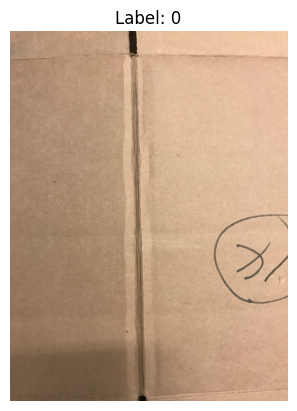

In [ ]:
data = dataset[0]
image = data["image"]
label = data["label"]

plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## Exploratory Image Analysis

### Label Distribution

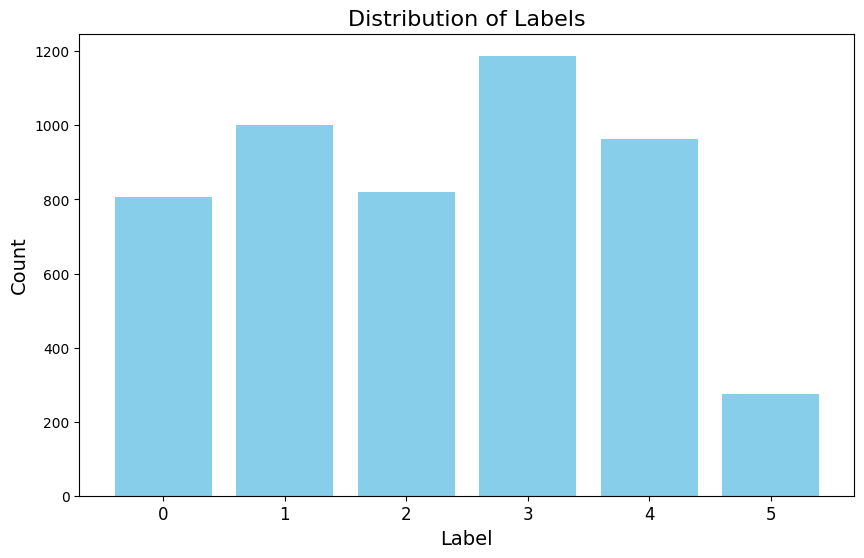

In [ ]:
label_counts = Counter(dataset['label'])

plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Labels", fontsize=16)
plt.xticks(list(label_counts.keys()), fontsize=12)
plt.show()

### Sample Images

Displaying sample images for: Cardboard


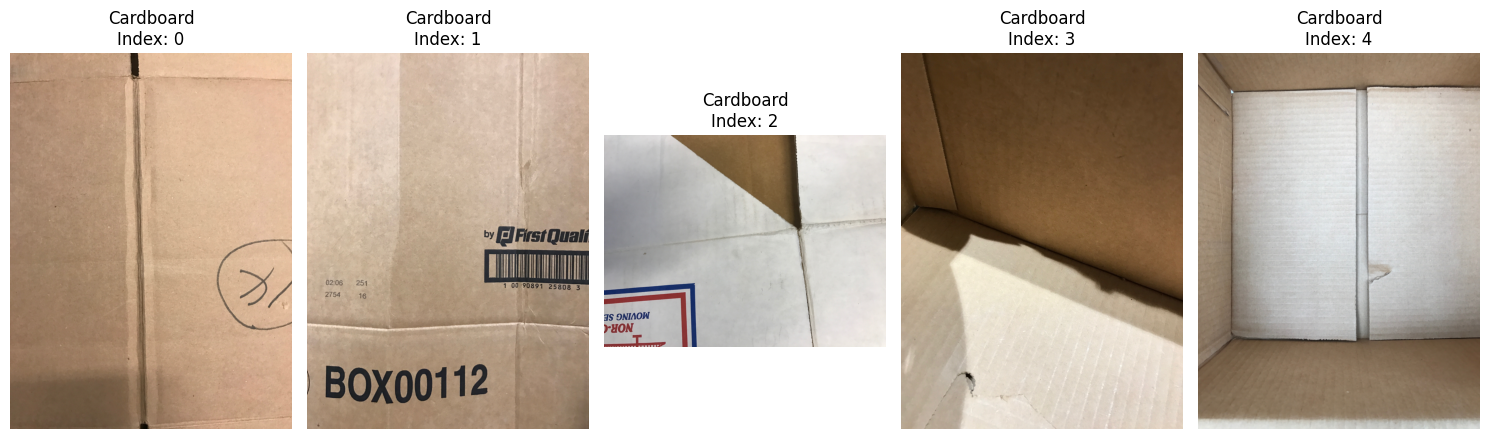

Displaying sample images for: Glass


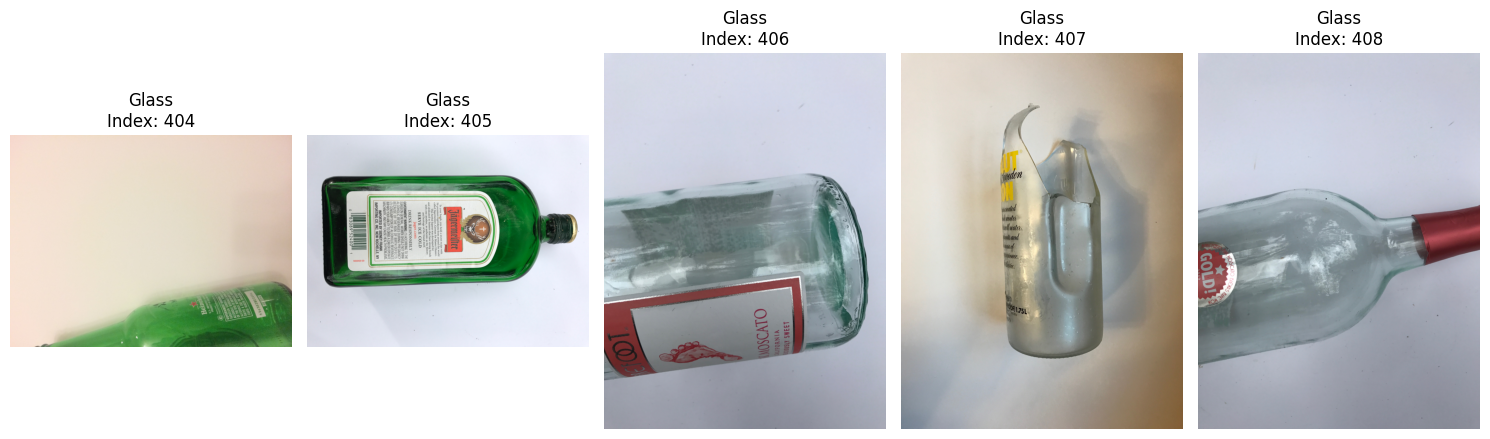

Displaying sample images for: Metal


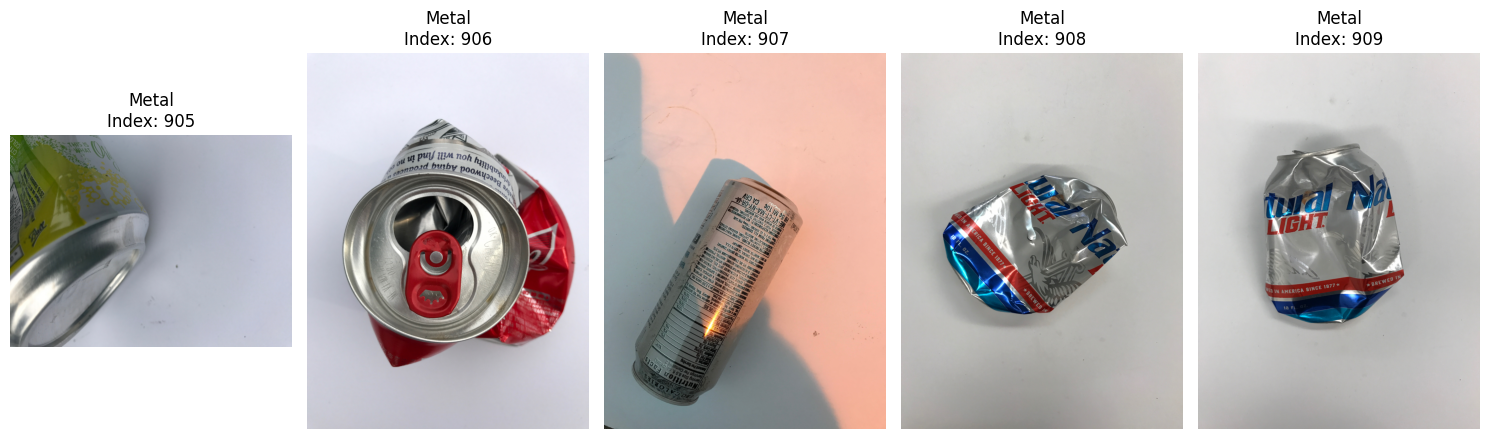

Displaying sample images for: Paper


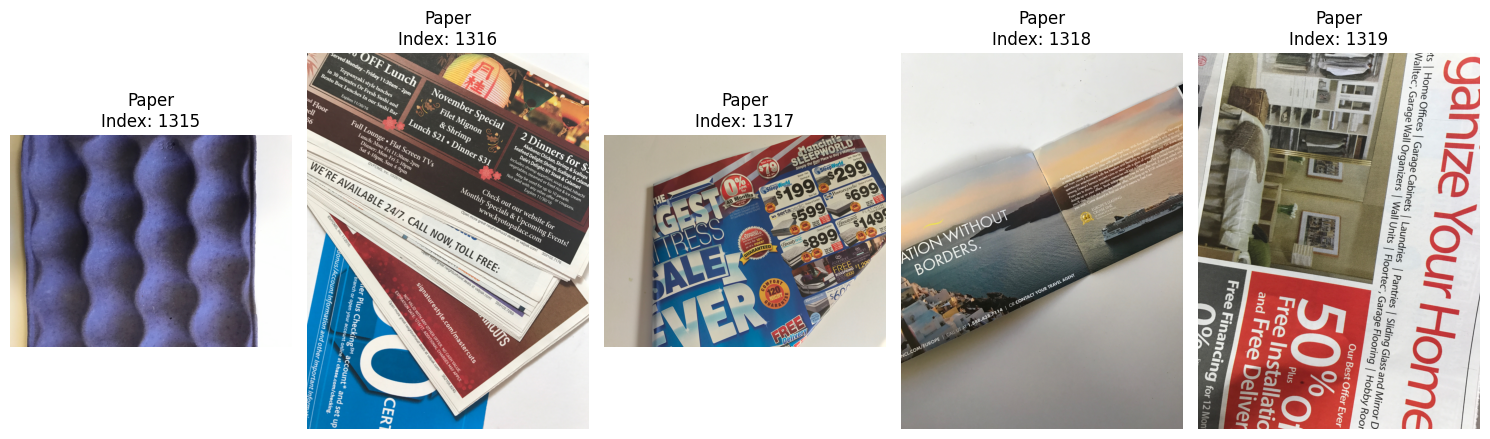

Displaying sample images for: Plastic


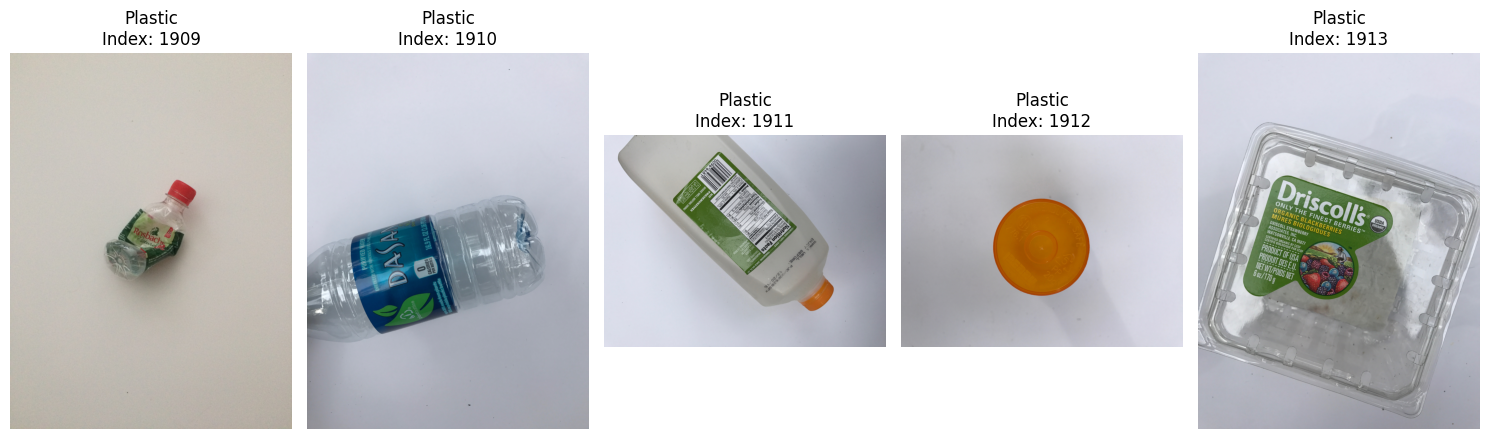

Displaying sample images for: Trash


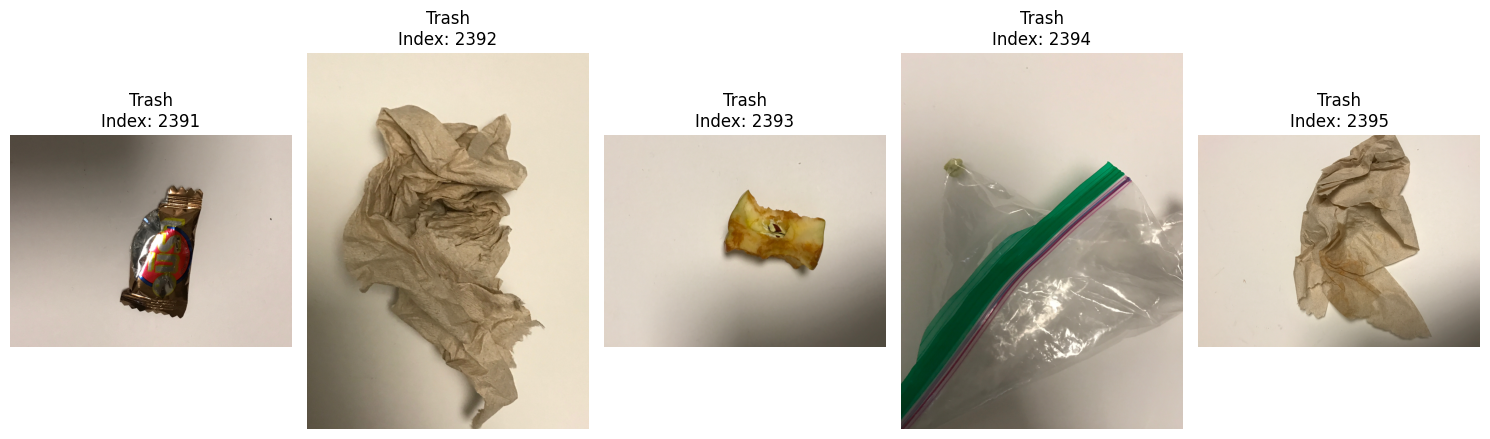

In [ ]:
def show_sample_images(dataset, sample_indices, title):
    n_images = len(sample_indices)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        image = dataset[idx]["image"]
        plt.subplot(1, n_images, i + 1)
        plt.imshow(image)
        plt.title(f"{title}\nIndex: {idx}", fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

samples = {
    "Cardboard": [0, 1, 2, 3, 4],
    "Glass": [404, 405, 406, 407, 408],
    "Metal": [905, 906, 907, 908, 909],
    "Paper": [1315, 1316, 1317, 1318, 1319],
    "Plastic": [1909, 1910, 1911, 1912, 1913],
    "Trash": [2391, 2392, 2393, 2394, 2395],
}

for label, indices in samples.items():
    print(f"Displaying sample images for: {label}")
    show_sample_images(dataset, indices, label)

## Data Preparation

### Konversi ke Tensor

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TrashNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

trashnet_dataset = TrashNetDataset(dataset, transform=transform)

batch_size = 32
train_loader = DataLoader(trashnet_dataset, batch_size=batch_size, shuffle=True)

### Split Dataset

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(trashnet_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 3537
Number of validation samples: 1010
Number of test samples: 507


### Sample Data Visualization

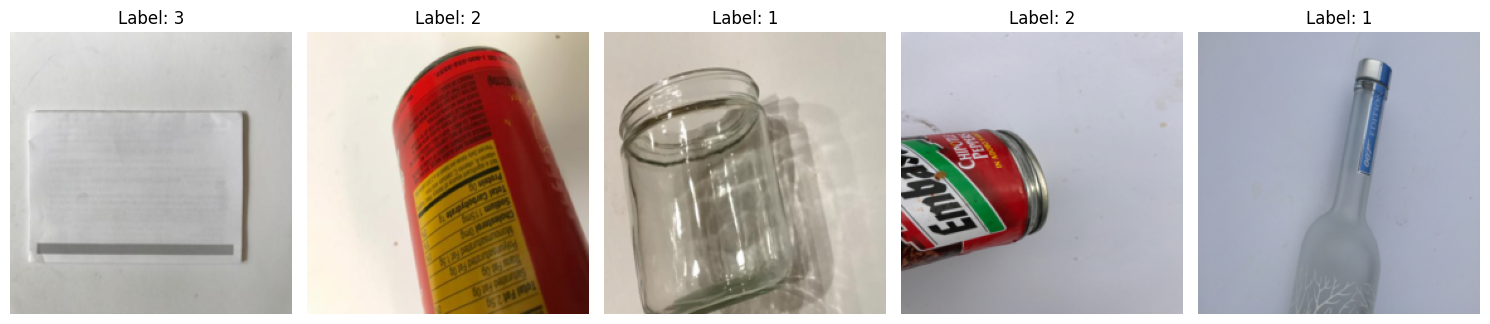

In [ ]:
def show_preprocessed_images(loader, n_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for i in range(n_images):
        image = images[i].permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)

        plt.subplot(1, n_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[i].item()}", fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_preprocessed_images(train_loader)

## Modelling

#### Wandb

In [ ]:
! pip install wandb

In [13]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [14]:
import wandb

wandb.init(
    project="trash-classification-cnn",
    config={
        "epochs": 10,
        "batch_size": 32,
        "learning_rate": 0.001,
        "architecture": "CNN",
        "num_classes": 6
    }
)

#### Build Model

In [15]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(-1, 64 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

#### Loss Function and Optimizer

In [16]:
num_classes = 6

model = CNNModel(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Summary

In [17]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                  [-1, 512]      25,690,624
            Linear-8                    [-1, 6]           3,078
Total params: 25,717,286
Trainable params: 25,717,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.40
Params size (MB): 98.10
Estimated Total Size (MB): 112.08
----------------------------------------------------------------


#### Training Function

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f"Epoch [{epoch+1}/{epochs}]")
        train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_progress.set_postfix({"Loss": loss.item()})

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")

        wandb.log({"train_loss": avg_train_loss, "train_accuracy": train_accuracy, "epoch": epoch + 1})

        val_loss, val_accuracy = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}%")

    wandb.log({"val_loss": avg_val_loss, "val_accuracy": val_accuracy})

    return avg_val_loss, val_accuracy

#### Training

In [21]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
torch.save(model.state_dict(), "../model/cnn.pth")

Epoch [1/10]


Epoch 1/10, Loss: 1.4251, Train Accuracy: 42.38%
Validation Loss: 1.1681, Validation Accuracy: 54.55%
Epoch [2/10]


Epoch 2/10, Loss: 0.9731, Train Accuracy: 64.29%
Validation Loss: 0.9792, Validation Accuracy: 64.06%
Epoch [3/10]


Epoch 3/10, Loss: 0.6303, Train Accuracy: 77.10%
Validation Loss: 0.9365, Validation Accuracy: 69.21%
Epoch [4/10]


Epoch 4/10, Loss: 0.3323, Train Accuracy: 88.44%
Validation Loss: 1.1399, Validation Accuracy: 65.84%
Epoch [5/10]


Epoch 5/10, Loss: 0.1405, Train Accuracy: 95.19%
Validation Loss: 1.4736, Validation Accuracy: 67.03%
Epoch [6/10]


Epoch 6/10, Loss: 0.0888, Train Accuracy: 97.37%
Validation Loss: 1.5229, Validation Accuracy: 69.21%
Epoch [7/10]


Epoch 7/10, Loss: 0.0390, Train Accuracy: 98.98%
Validation Loss: 1.5347, Validation Accuracy: 71.58%
Epoch [8/10]


Epoch 8/10, Loss: 0.0561, Train Accuracy: 98.47%
Validation Loss: 1.5854, Validation Accuracy: 68.12%
Epoch [9/10]


Epoch 9/10, Loss: 0.0617, Train Accuracy: 98.25%
Validation Loss: 1.6058, Validation Accuracy: 69.90%
Epoch [10/10]


Epoch 10/10, Loss: 0.0232, Train Accuracy: 99.38%
Validation Loss: 1.8384, Validation Accuracy: 69.31%


## Evaluation

#### Model Evaluation

CNN - Validation Accuracy: 69.31%
CNN - Precision: 0.70
CNN - Recall: 0.69
CNN - F1-Score: 0.70


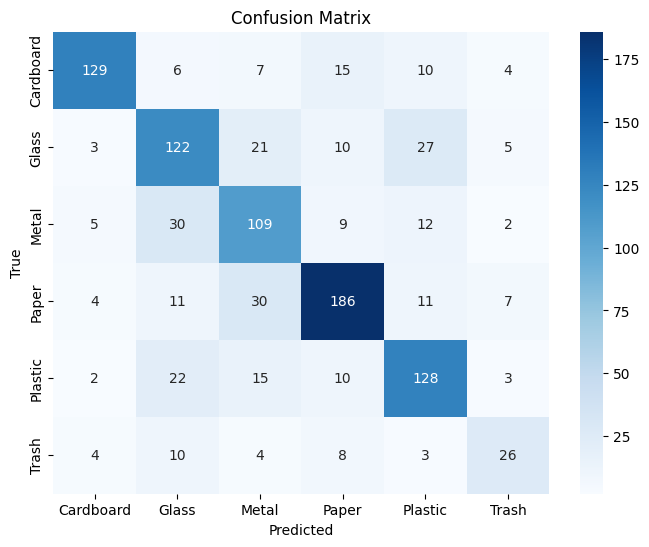

In [32]:
def evaluate_model(model, val_loader, device, model_name):
    model.eval()
    true_labels = []
    predicted_labels = []

    val_progress = tqdm(val_loader, desc=f"Evaluating {model_name}", leave=False)
    with torch.no_grad():
        for inputs, labels in val_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

    print(f"{model_name} - Validation Accuracy: {accuracy * 100:.2f}%")
    print(f"{model_name} - Precision: {precision:.2f}")
    print(f"{model_name} - Recall: {recall:.2f}")
    print(f"{model_name} - F1-Score: {f1:.2f}")

    return cm, accuracy, precision, recall, f1

class_labels = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

cm, accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device, "CNN")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Test Prediction

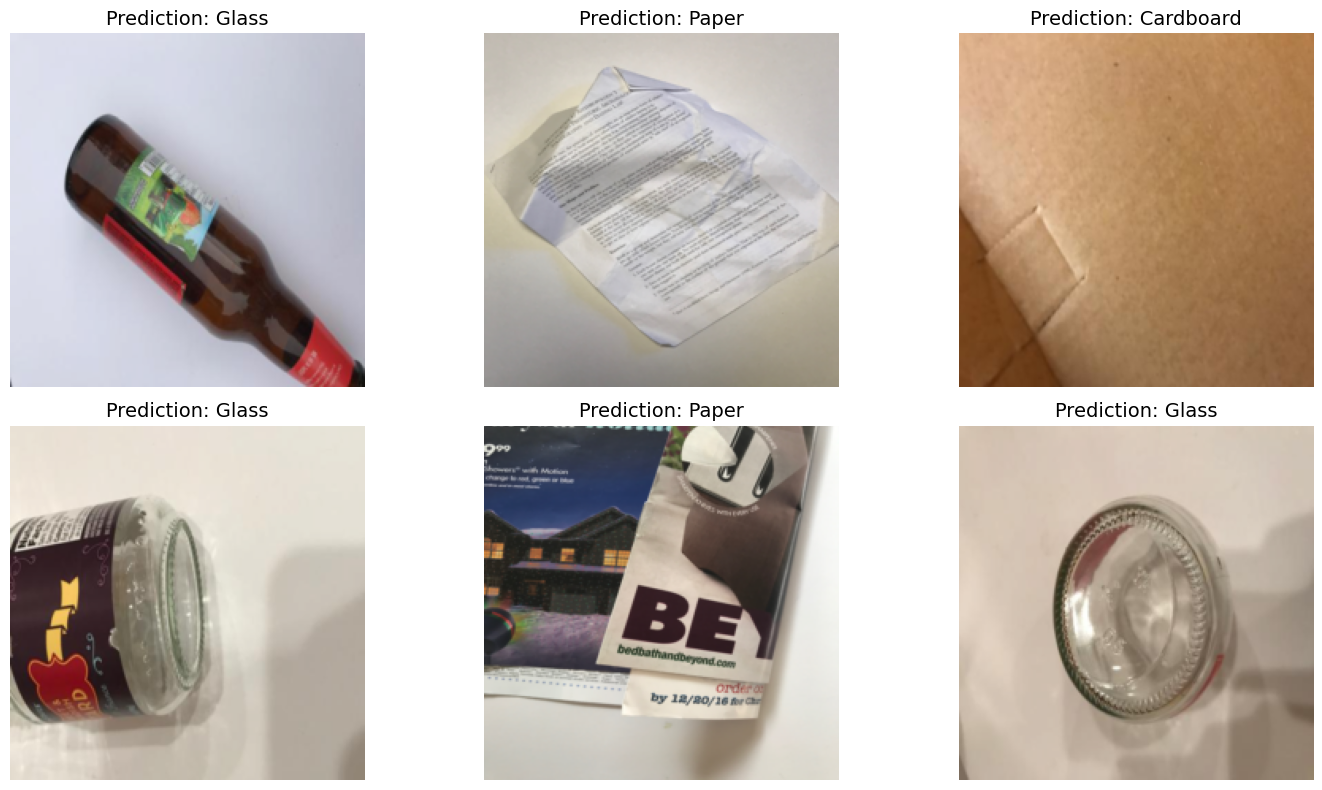

In [35]:
def display_sample_predictions(model, test_loader, device):
    model.eval()
    images_list = []
    predictions_list = []

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            images_list.extend(images.cpu())
            predictions_list.extend(predicted.cpu().numpy())
            if len(images_list) > 50:
                break

    total_indices = list(range(len(images_list)))
    selected_indices = random.sample(total_indices, 6)

    selected_images = [images_list[i] for i in selected_indices]
    selected_predictions = [predictions_list[i] for i in selected_indices]

    plt.figure(figsize=(15, 8))
    for idx, (image, prediction) in enumerate(zip(selected_images, selected_predictions)):
        image = image.permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        image = image.clip(0, 1)

        plt.subplot(2, 3, idx + 1)
        plt.imshow(image)
        plt.title(f"Prediction: {class_labels[prediction]}", fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_sample_predictions(model, test_loader, device)